# Libraries Import

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data preprocessing

In [2]:
file_infl    = r"C:\Users\shres\OneDrive\Desktop\EXL-Hackathon\data_sets\inflation.csv"
file_gdp     = r"C:\Users\shres\OneDrive\Desktop\EXL-Hackathon\data_sets\GDP.csv"
file_oowb    = r"C:\Users\shres\OneDrive\Desktop\EXL-Hackathon\data_sets\out_of_work_benefits.csv"
file_ecn_ina = r"C:\Users\shres\OneDrive\Desktop\EXL-Hackathon\data_sets\economically_inactive.csv"
file_red     = r"C:\Users\shres\OneDrive\Desktop\EXL-Hackathon\data_sets\redundancies.csv"
file_tot_pay = r"C:\Users\shres\OneDrive\Desktop\EXL-Hackathon\data_sets\total_pay.csv"
file_unemp_rt= r"C:\Users\shres\OneDrive\Desktop\EXL-Hackathon\data_sets\unemployment_rate.csv"
file_prcd    = r"C:\Users\shres\OneDrive\Desktop\EXL-Hackathon\data_sets\uk.xlsx"
#-----------------------------------------------------------------------#
df_inf     = pd.read_csv(file_infl)
df_gdp     = pd.read_csv(file_gdp)
df_oowb    = pd.read_csv(file_oowb)
df_ecn_ina = pd.read_csv(file_ecn_ina)
df_red     = pd.read_csv(file_red)
df_tot_pay = pd.read_csv(file_tot_pay)
df_unemp_rt= pd.read_csv(file_unemp_rt)
df_prcd    = pd.read_excel(file_prcd)
#-----------------------------------------------------------------------#
df_inf      = df_inf.iloc[177:]
df_gdp      = df_gdp.iloc[82:]
df_oowb     = df_oowb.iloc[267:]
df_ecn_ina  = df_ecn_ina.iloc[267:]
df_red      = df_red.iloc[146:]
df_tot_pay  = df_tot_pay.iloc[7:]
df_unemp_rt = df_unemp_rt.iloc[267:]
df_prcd     = df_prcd.iloc[:-3,:]
#-----------------------------------------------------------------------#
df_inf.columns      = ['MONTH','INFL']
df_gdp.columns      = ['MONTH','GDP']
df_oowb.columns     = ['MONTH','OOWB']
df_ecn_ina.columns  = ['MONTH','ECN_INA']
df_red.columns      = ['MONTH','RED']
df_tot_pay.columns  = ['MONTH','TOT_PAY']
df_unemp_rt.columns = ['MONTH','UNEMP_RT']
#-----------------------------------------------------------------------#
df_list = [df_inf, df_gdp, df_oowb, df_ecn_ina,
           df_red, df_tot_pay, df_unemp_rt, df_prcd]
#-----------------------------------------------------------------------#
for dfs in df_list:
    dfs.reset_index(drop=True, inplace=True)
#-----------------------------------------------------------------------#
df_prcd.rename(columns={'Time':'DATE'},inplace=True)
df_prcd['DATE'] = df_prcd['DATE'].astype(str)
#-----------------------------------------------------------------------#
df_gdp.loc[:,'year'] = df_gdp['MONTH'].str.split().str[0]
df_gdp.loc[:,'quarter'] = df_gdp['MONTH'].str.split().str[-1]
df_gdp = df_gdp.loc[df_gdp.index.repeat(3)].reset_index(drop=True)
df_gdp['#date'] = pd.date_range(start='01-01-1955', periods=len(df_gdp), freq='M')
df_gdp['#date'] = df_gdp['#date'].astype(str)
df_gdp['DATE'] = df_gdp['#date'].str[:8] + '01'
df_gdp['DATE'] = pd.to_datetime(df_gdp['DATE'])

df_gdp['GDP'] = df_gdp['GDP'].astype(float)
df_gdp['AVG_GDP'] = df_gdp['GDP']/3

df_gdp.drop(columns=['MONTH','GDP','year','quarter','#date'],inplace=True)   
#-----------------------------------------------------------------------#
df_dates = [df_inf, df_oowb, df_ecn_ina, df_red, df_tot_pay, df_unemp_rt]

def add_dates(df):
    import datetime
    df.loc[:, 'month_abbr'] = df['MONTH'].str.split().str[-1].copy()
    df.loc[:, 'year'] = df['MONTH'].str.split().str[0].copy()
    df.loc[:,'#month'] = df['month_abbr'].apply(lambda x: datetime.datetime.strptime(x, "%b").month)
    df['#month'] = df['#month'].astype(str)
    df['#month'] = df['#month'].apply(lambda x: str(x).zfill(2))
    from datetime import datetime
    df['DATE'] = '01' + '-' + df['#month'] + '-' + df['year']
    df['DATE'] = df['DATE'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date())
    df.drop(columns=['MONTH','month_abbr','year','#month'],inplace=True)
    df = df.set_index('DATE')
    return df
#-----------------------------------------------------------------------#
for dataframe in df_dates:
    add_dates(dataframe)
#-----------------------------------------------------------------------#    
df_inf      = df_inf.set_index('DATE')
df_gdp      = df_gdp.set_index('DATE')     
df_oowb     = df_oowb.set_index('DATE')     
df_ecn_ina  = df_ecn_ina.set_index('DATE')  
df_red      = df_red.set_index('DATE')      
df_tot_pay  = df_tot_pay.set_index('DATE')  
df_unemp_rt = df_unemp_rt.set_index('DATE') 
df_prcd     = df_prcd.set_index('DATE')

df = pd.DataFrame()
df = pd.concat([df_unemp_rt, df_gdp, df_red, df_tot_pay, df_oowb], axis=1)

df_mod_1 = df.dropna()
df_mod_1 = df_mod_1.astype(float)

df_prcd = df_prcd.reset_index()
df_prcd['DATE'] = pd.to_datetime(df_prcd['DATE'])
df_prcd = df_prcd.loc[df_prcd['DATE']>='2001-03-01']
df_prcd.drop(columns='Deposit_Rate',inplace=True)

drop_list = []
for column in df_prcd.columns:
    first_non_null_index = df_prcd[column].first_valid_index()
    first_non_null_value = df_prcd.loc[first_non_null_index, column]
    last_non_null_index = df_prcd[column].last_valid_index()
    last_non_null_value = df_prcd.loc[last_non_null_index, column]
#     print(f"{column}: {first_non_null_value}: {df_prcd['Time'][first_non_null_index]}")
    if (df_prcd['DATE'][first_non_null_index] > pd.to_datetime('2001-03-01 00:00:00')) or (df_prcd['DATE'][last_non_null_index] < pd.to_datetime('2022-12-01 00:00:00')):
        drop_list.append(column)
        
df_prcd.drop(columns=drop_list, inplace=True)
df_prcd = df_prcd.set_index('DATE')

df_prcd.drop(columns=['Unemployment_Rate_MEN','Unemployment_Rate_TOT',
                      'Unemployment_Rate_WOMEN','Prices|Consumer_Price_Index|All_items|Index|Base_Year-2010=100'],inplace=True)

df_concat = pd.concat([df_mod_1, df_prcd], axis=1)
df_mod_2 = df_concat.dropna()
df_mod = pd.DataFrame()
df_mod = df_mod_2
df_mod = df_mod.astype(float)

del df_inf,df_gdp,df_oowb,df_ecn_ina,df_red,df_tot_pay,df_unemp_rt,df_prcd,df_mod_1,df_mod_2

# Statoinarity check

In [3]:
for col in df_mod.columns:
    print("---------- " + col + " ----------------")
    ad_fuller_result = adfuller(df_mod[col])
    print(f'p-value: {ad_fuller_result[1]}')

---------- UNEMP_RT ----------------
p-value: 0.589510884697754
---------- AVG_GDP ----------------
p-value: 0.5549221408905071
---------- RED ----------------
p-value: 0.0189937474798934
---------- TOT_PAY ----------------
p-value: 0.2664706286476579
---------- OOWB ----------------
p-value: 0.0689995033490908
---------- Change_in_Inventories|Nominal|Undjusted|Domestic_Currency ----------------
p-value: 9.718139113298847e-05
---------- Exports_of_Goods_and_Services|Nominal|Undjusted|Domestic_Currency ----------------
p-value: 0.9699841900058159
---------- Government_Consumption_Expenditure|Nominal|Undjusted|Domestic_Currency ----------------
p-value: 0.9535854868361272
---------- Gross_Domestic_Product|Nominal|Undjusted|Domestic_Currency ----------------
p-value: 0.9842779377712781
---------- Gross_Fixed_Capital_Formation|Nominal|Undjusted|Domestic_Currency ----------------
p-value: 0.9795057025621959
---------- Household_Consumption_Expenditure|incl._NPISHs|Nominal|Undjusted|Domestic

In [4]:
for col in df_mod.columns:
    print("---------- " + col + " ----------------")
    ad_fuller_result = adfuller(df_mod[col].diff()[1:])
    print(f'p-value: {ad_fuller_result[1]}')

---------- UNEMP_RT ----------------
p-value: 0.001123521088745838
---------- AVG_GDP ----------------
p-value: 3.146666840566663e-22
---------- RED ----------------
p-value: 1.3783478090957498e-09
---------- TOT_PAY ----------------
p-value: 0.00018578695448844985
---------- OOWB ----------------
p-value: 0.00018899139282902143
---------- Change_in_Inventories|Nominal|Undjusted|Domestic_Currency ----------------
p-value: 0.0006446849638442042
---------- Exports_of_Goods_and_Services|Nominal|Undjusted|Domestic_Currency ----------------
p-value: 0.04244346066997246
---------- Government_Consumption_Expenditure|Nominal|Undjusted|Domestic_Currency ----------------
p-value: 0.10172816494692466
---------- Gross_Domestic_Product|Nominal|Undjusted|Domestic_Currency ----------------
p-value: 0.017858155412666426
---------- Gross_Fixed_Capital_Formation|Nominal|Undjusted|Domestic_Currency ----------------
p-value: 0.040112893501356044
---------- Household_Consumption_Expenditure|incl._NPISHs|No

# Data filtering

In [5]:
df_mod = df_mod[['UNEMP_RT','AVG_GDP','RED','OOWB']]

In [6]:
for col in df_mod.columns:
    print("---------- " + col + " ----------------")
    ad_fuller_result = adfuller(df_mod[col].diff()[1:])
    print(f'p-value: {ad_fuller_result[1]}')

---------- UNEMP_RT ----------------
p-value: 0.001123521088745838
---------- AVG_GDP ----------------
p-value: 3.146666840566663e-22
---------- RED ----------------
p-value: 1.3783478090957498e-09
---------- OOWB ----------------
p-value: 0.00018899139282902143


# Causality test

In [7]:
for i in range(1,(df_mod.shape[-1])):
    print(f'{df_mod.columns[i]} ----> UNEMP_RT?\n')
    granger_ = grangercausalitytests(df_mod[['UNEMP_RT', df_mod.columns[i]]], 4)
    print('------------------')

AVG_GDP ----> UNEMP_RT?


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.1662 , p=0.0003  , df_denom=258, df_num=1
ssr based chi2 test:   chi2=13.3193 , p=0.0003  , df=1
likelihood ratio test: chi2=12.9906 , p=0.0003  , df=1
parameter F test:         F=13.1662 , p=0.0003  , df_denom=258, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1594  , p=0.0167  , df_denom=255, df_num=2
ssr based chi2 test:   chi2=8.4818  , p=0.0144  , df=2
likelihood ratio test: chi2=8.3464  , p=0.0154  , df=2
parameter F test:         F=4.1594  , p=0.0167  , df_denom=255, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7681  , p=0.0423  , df_denom=252, df_num=3
ssr based chi2 test:   chi2=8.5351  , p=0.0362  , df=3
likelihood ratio test: chi2=8.3974  , p=0.0385  , df=3
parameter F test:         F=2.7681  , p=0.0423  , df_denom=252, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:      

# Train-test split

In [8]:
df_train = df_mod[:-12]
df_test  = df_mod[-12:]
print('train size', df_train.shape)
print('test size', df_test.shape)

train size (250, 4)
test size (12, 4)


# Best order estimation

In [9]:
model = VAR(df_train.diff()[1:])

In [10]:
sorted_order=model.select_order(maxlags=30)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        18.67       18.74   1.288e+08       18.70
1        17.49       17.80   3.942e+07       17.61
2        17.28       17.84   3.204e+07       17.51
3        16.02      16.82*   9.062e+06       16.34
4        16.01       17.07   9.029e+06       16.44
5        16.00       17.30   8.879e+06       16.52
6        15.59       17.14   5.935e+06       16.22
7        15.58       17.38   5.886e+06       16.31
8        15.59       17.63   5.958e+06       16.42
9        15.20       17.49   4.038e+06      16.12*
10       15.18       17.72   3.981e+06       16.20
11       15.13       17.91   3.800e+06       16.25
12       15.12       18.15   3.798e+06       16.34
13      15.06*       18.34  3.605e+06*       16.38
14       15.10       18.63   3.798e+06       16.53
15       15.12       18.89   3.899e+06       16.64
16       15.09       19.12   3.

# Model training

In [11]:
var_model = VARMAX(df_train, order=(13,8),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                     Statespace Model Results                                     
Dep. Variable:     ['UNEMP_RT', 'AVG_GDP', 'RED', 'OOWB']   No. Observations:                  250
Model:                                        VARMA(13,8)   Log Likelihood               -3063.794
                                              + intercept   AIC                           6827.588
Date:                                    Wed, 03 May 2023   BIC                           8060.100
Time:                                            17:51:32   HQIC                          7323.638
Sample:                                        03-01-2001                                         
                                             - 12-01-2021                                         
Covariance Type:                                      opg                                         
Ljung-Box (L1) (Q):     0.07, 0.03, 0.02, 0.00   Jarque-Bera (JB):   1.62, 29041.84, 36.85, 1840.52
Prob(Q): 

# Forecasing

In [12]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(df_train),end=len(df_train) + n_forecast-1)

predictions=predict.predicted_mean

In [13]:
predictions = predictions[['UNEMP_RT']]
predictions.rename(columns={'UNEMP_RT':'UNEMP_RT_pred'},inplace=True)

In [14]:
test_vs_pred=pd.concat([df_test,predictions],axis=1)

# Model Evaluation

<AxesSubplot:>

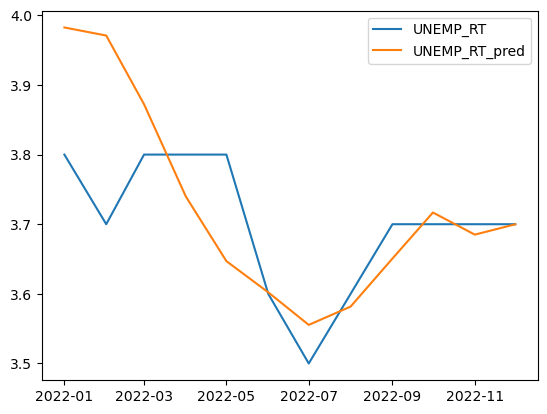

In [15]:
test_vs_pred['UNEMP_RT'].plot(legend=True)
test_vs_pred['UNEMP_RT_pred'].plot(legend=True)

In [16]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

rmse_unemp_rt=math.sqrt(mean_squared_error(predictions['UNEMP_RT_pred'],df_test['UNEMP_RT']))
print('Mean value of UNEMP_RT is : {}. Root Mean Squared Error is :{}'.format(mean(df_test['UNEMP_RT']),rmse_unemp_rt))

Mean value of UNEMP_RT is : 3.7. Root Mean Squared Error is :0.11006306708840581
